# Prédiction de séries temporelles appliqué au déplacement des baleines

## Importation des données

D'après l'analyse réalisée dans le précédent notebook, on choisit le dataset *Blue and fin whales, Southern California (2014-2015)* pour commencer nos prédictions.

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv("data/Blue and fin whales Southern California 2014-2015 - Fastloc GPS data.csv")

In [4]:
df = df[df['manually-marked-outlier'].isna()] # 19 outliers sur 17169 points
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
whales = []
for id in df['individual-local-identifier'].unique():
    whales.append(df[df['individual-local-identifier']==id][['timestamp','location-lat','location-long']])

## Analyse temporelle

Les intervalles de temps de mesures sont ne sont pas réguliers dans le dataset. On souhaite donc transformer le dataset en une série temporelle avec intervalle de temps régulier pour chaque individu.
Pour déterminer l'intervalle de temps à utiliser, regardons comment sont répartis les intervalles de mesures pour chaque individu du dataset :

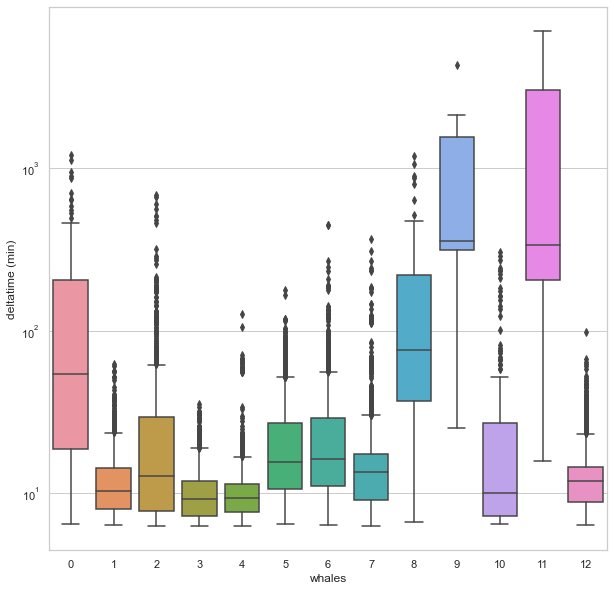

In [14]:
diffs = []
for i in range(len(whales)):
    diff = whales[i]['timestamp'].diff()/np.timedelta64(1, 'm')
    diff = diff.to_frame()
    diff['num'] = i
    diffs.append(diff)
diffs = pd.concat(diffs)
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")
bx = sns.boxplot(data = diffs, x="num", y="timestamp")
bx.set_ylabel("deltatime (min)")
bx.set_xlabel("whales")
bx.set_yscale("log")

On peut voir que la plupart des individus du dataset ont leurs intervalles de mesures distribués entre 5 et 20 minutes, on choisit donc un intervalle de temps fixe de **20 minutes** pour le resampling des séries temporelles.

## Préparation des séries temporelles

### Transformation en série temporelle à intervalle fixe

Pour transformer les séries temporelles à intervalles irréguliers de chaque individu en séries temporelles à intervalle fixe, on applique la méthode `resample` de *pandas* à notre dataset puis on interpole les nouveaux points à l'aide des données existantes avec `interpolate`.

De plus, pour prendre en compte la saisonnalité annuelle et journalière, on ajoute deux features *daycos* et *yearcos* qui correspondent au cosinus du temps avec une période respective de 24h et 1 année.

In [6]:
interval = '20min'
datas = []
for whale in whales:
    data = whale.set_index('timestamp').resample(interval).mean().interpolate(method='polynomial',order=2)
    # data['timestamp'] = data['timestamp']/np.timedelta64(1, 's')
    data['daycos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('D').to_timestamp().timestamp())*2*np.pi/86400), axis=1)
    data['yearcos'] = data.apply(lambda r: np.cos((r.name.timestamp() - r.name.to_period('Y').to_timestamp().timestamp())*2*np.pi/31536000), axis=1)
    data[['location-lat','location-long']] = data[['location-lat','location-long']].diff()
    data = data.iloc[1:]
    datas.append(data)

### Transformation en dataset supervisé

Pour pouvoir prédire les points suivants en fonction des points précédents à l'aide des estimateurs de Machine Learning habituels, il faut transformer nos séries temporelles en dataset supervisé $X$, $y$ où une ligne de $X$ correspond à $n$ points de la série et le point $y$ associé correspond au point à prédire suivant les $n$ points de $X$.

In [132]:
def to_Xy(data, prepoints = 1):
    '''
    Transformation d'une série temporelle data en dataset supervisé
    avec prepoints le nombre de points précédents pour prédire le suivant
    '''
    data = data.copy()
    for i in range(1,prepoints + 1):
        data[f'pre-location-lat{i}'] = data['location-lat'].shift(i)
        data[f'pre-location-long{i}'] = data['location-long'].shift(i)
    data = data.iloc[prepoints:]
    X = data.drop(['location-lat','location-long'], axis=1)
    y = data[['location-lat','location-long']]
    return X,y
            

In [133]:
data = datas[4]
prepoints = 10 # 
i_split = int(len(data)*0.8)
X, y = to_Xy(data, prepoints = prepoints)
X_train = X[:i_split]
X_test = X[i_split:]
y_train = y[:i_split]
ylat_train = y_train['location-lat']
ylong_train = y_train['location-long']
y_test = y[i_split:]
ylat_test = y_test['location-lat']
ylong_test = y_test['location-long']

Afin de prédire $y$ de la latitude et $y$ de la longitude en fonction des deux estimateurs respectifs et de $X$, on définit la fonction suivante. De plus, on peut prédire non pas le point suivant mais un point après un certain nombre $horizon$ de pas de temps. Pour cela, on utilise la méthode de *rolling* qui consiste à ajouter la prédiction du point suivant dans $X$ pour prédire le point encore après jusqu'à arriver au nombre de points voulu $horizon$.

In [20]:
def predict(clf_lat, clf_long, X, horizon = 1):
    prepoints = X.shape[1]//2 - 1
    X = X.copy()
    for p in range(horizon):
        X_pre = X.copy()
        ylat_next = clf_lat.predict(X)
        ylong_next = clf_long.predict(X)
        X = X[['daycos','yearcos']].copy()
        X['pre-location-lat1'] = ylat_next
        X['pre-location-long1'] = ylong_next
        for i in range(2,prepoints + 1):
            X[f'pre-location-lat{i}'] = X_pre[f'pre-location-lat{i-1}']
            X[f'pre-location-long{i}'] = X_pre[f'pre-location-long{i-1}']
            
    return ylat_next, ylong_next

## Prediction avec Regression Linéaire

In [95]:
reg_lat = LinearRegression().fit(X_train,ylat_train)
reg_long = LinearRegression().fit(X_train,ylong_train)

In [63]:
print(reg_lat.coef_)
print(reg_long.coef_)

[ 6.42688648e-05 -7.04253931e-04  7.38579820e-01  3.33514937e-03
 -1.44326947e-01 -3.36790638e-02  1.31205120e-01  1.09145971e-02
  1.75195245e-02  2.54958114e-02  1.19550215e-02 -3.96952688e-02
 -1.07411064e-03  3.37746365e-02  6.21523852e-03 -8.46852850e-03
 -2.77510735e-02 -3.52523021e-02  3.31208522e-02 -1.31309363e-02
 -4.27159911e-02  7.42804508e-04  7.68196029e-02  5.47261524e-03
  1.38831982e-02 -1.06315682e-02  2.07535369e-02 -1.07422041e-02
 -5.15254077e-02  4.04402193e-02  4.05475579e-02 -1.62017502e-02
  1.55566749e-02  7.26392412e-02 -1.85363900e-02 -6.01534556e-02
 -1.77819428e-02  3.93064067e-02  4.01506114e-02  5.38082267e-03
  1.93810745e-02 -7.65861268e-03]
[-6.94023483e-05 -4.60237481e-03 -2.02544783e-01  7.11194376e-01
  1.42760649e-01 -1.18731392e-01 -3.74003285e-02  7.65664603e-02
  3.18035109e-02  3.88117509e-03  1.85683207e-02  3.11439973e-02
 -2.75250313e-02 -3.02841657e-02 -2.94372606e-02  4.72418640e-02
  6.70890276e-02 -3.37198849e-02 -5.77850619e-02  2.6604

In [96]:
horizon = 10
ylat_pred, ylong_pred = predict(reg_lat, reg_long, X_test, horizon=horizon)

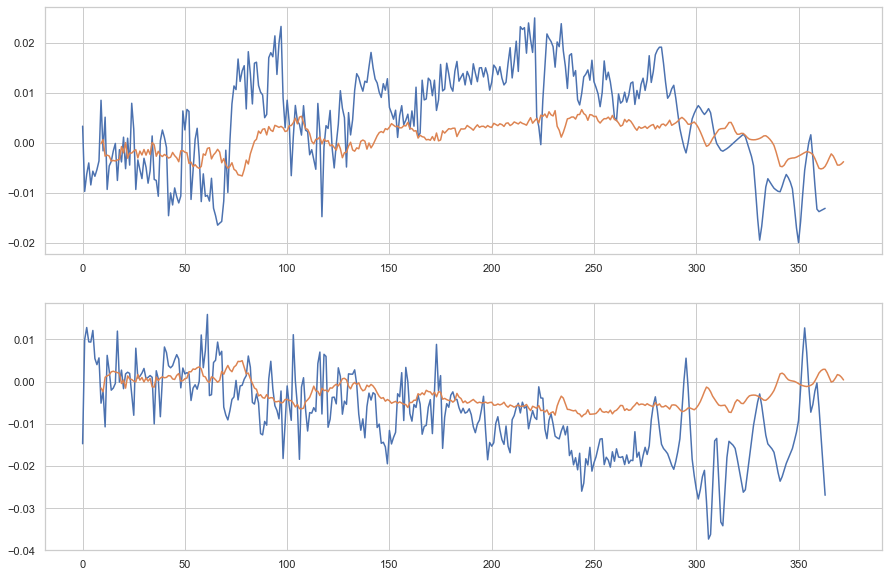

In [97]:
a=0
b=len(y_test)
points = np.array(range(len(y_test[a:b])))
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(points,ylat_test[a:b])
plt.plot(points + horizon -1,ylat_pred[a:b])
plt.subplot(2,1,2)
plt.plot(points,ylong_test[a:b])
plt.plot(points + horizon -1,ylong_pred[a:b])

In [98]:
mean_squared_error(ylat_pred[:-horizon+1],ylat_test[horizon-1:])

8.734716186344664e-05

In [99]:
mean_squared_error(ylong_pred[:-horizon+1],ylong_test[horizon-1:])

9.477141193329819e-05

## Prediction with AdaBoost

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

In [120]:
rng = 0
base = DecisionTreeRegressor(max_depth=10)
adareg_lat = AdaBoostRegressor(base,n_estimators=100,random_state = rng).fit(X_train,ylat_train)
adareg_long = AdaBoostRegressor(base,n_estimators=100,random_state = rng).fit(X_train,ylong_train)

In [121]:
horizon = 10
ylat_pred, ylong_pred = predict(adareg_lat, adareg_long, X_test, horizon=horizon)

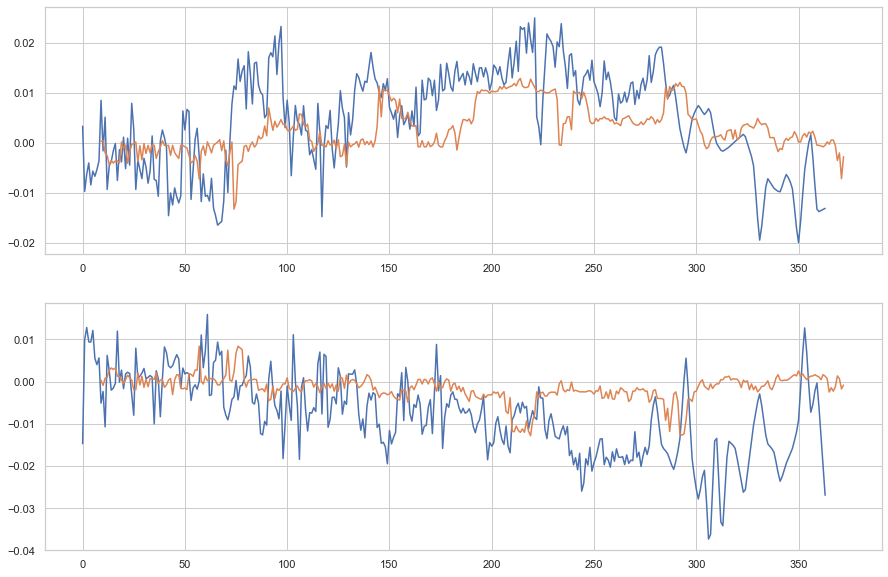

In [122]:
a=0
b=len(y_test)
points = np.array(range(len(y_test[a:b])))
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(points,ylat_test[a:b])
plt.plot(points + horizon -1,ylat_pred[a:b])
plt.subplot(2,1,2)
plt.plot(points,ylong_test[a:b])
plt.plot(points + horizon -1,ylong_pred[a:b])

In [123]:
mean_squared_error(ylat_pred[:-horizon+1],ylat_test[horizon-1:])

7.968982384352362e-05

In [124]:
mean_squared_error(ylong_pred[:-horizon+1],ylong_test[horizon-1:])

0.0001324202084759702

## Prediction RNN

Source https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [85]:
n = len(datas[7])
train_df = datas[7][0:int(n*0.8)]
val_df = datas[7][int(n*0.7):int(n*0.9)]
test_df = datas[7][int(n*0.9):]

print(len(train_df),len(val_df),len(test_df))

1666 208 417


In [115]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
        
        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result
    
    def plot(self, model=None, plot_col='location-lat', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(15, 10))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue
                
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=16)
            if model is not None:
                predictions = model(inputs)
                '''plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=16)'''
                plt.plot(self.label_indices, predictions[n, :, label_col_index],
                          marker='x', label='Predictions',
                          )

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')



In [137]:
wide_window = WindowGenerator(
    input_width=10, label_width=10, shift=1,
    label_columns=['location-lat'])


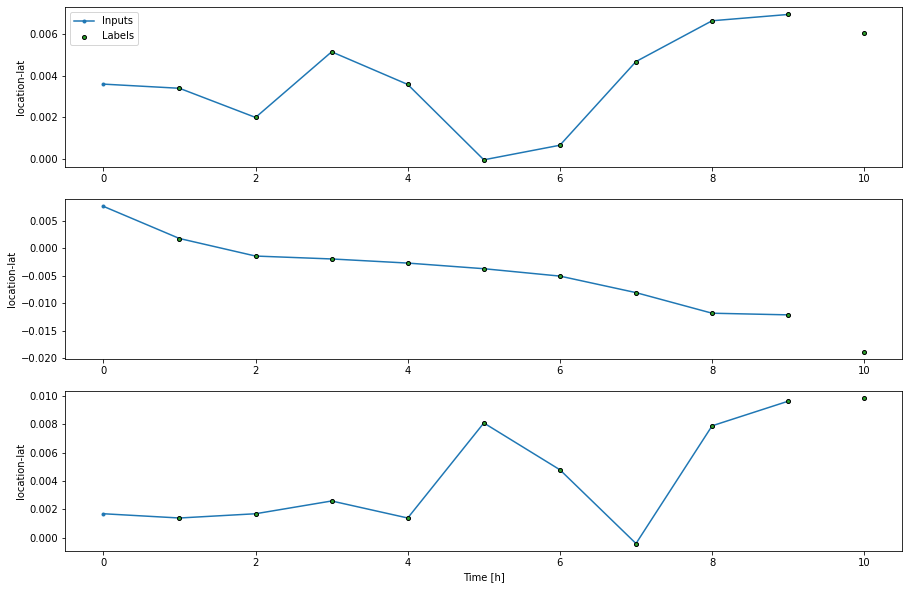

In [139]:
wide_window.plot()

In [140]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [141]:
MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.RMSprop(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [142]:
history = compile_and_fit(lstm_model, wide_window)

print(lstm_model.evaluate(wide_window.val))
print(lstm_model.evaluate(wide_window.test, verbose=0))


Epoch 1/40
52/52 [==============================] - 3s 14ms/step - loss: 0.0010 - mean_absolute_error: 0.0175 - val_loss: 8.2531e-05 - val_mean_absolute_error: 0.0075
Epoch 2/40
52/52 [==============================] - 0s 5ms/step - loss: 2.1755e-04 - mean_absolute_error: 0.0113 - val_loss: 1.3517e-04 - val_mean_absolute_error: 0.0101
Epoch 3/40
52/52 [==============================] - 0s 5ms/step - loss: 1.2923e-04 - mean_absolute_error: 0.0089 - val_loss: 1.3764e-04 - val_mean_absolute_error: 0.0101
Epoch 4/40
52/52 [==============================] - 0s 5ms/step - loss: 1.5035e-04 - mean_absolute_error: 0.0103 - val_loss: 4.9754e-05 - val_mean_absolute_error: 0.0057
Epoch 5/40
52/52 [==============================] - 0s 5ms/step - loss: 1.4040e-04 - mean_absolute_error: 0.0099 - val_loss: 1.3061e-04 - val_mean_absolute_error: 0.0101
Epoch 6/40
52/52 [==============================] - 0s 6ms/step - loss: 1.3905e-04 - mean_absolute_error: 0.0102 - val_loss: 1.0601e-04 - val_mean_absolu

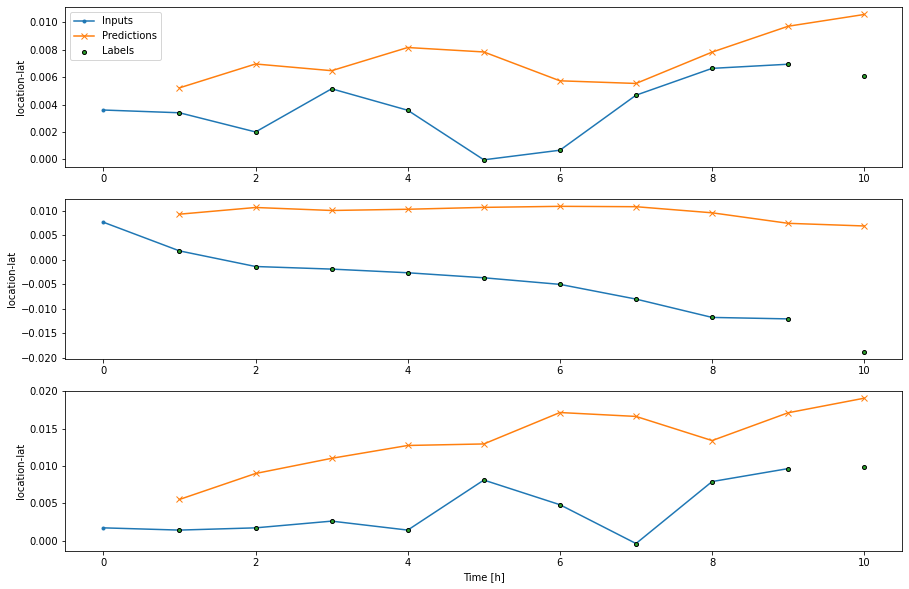

In [143]:
wide_window.plot(lstm_model)